In [21]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata 

In [22]:
# start with filtered, pre-processed data
adata = anndata.read_h5ad('/project/BDShackathon/teams/CnC/final_with_umap_and_images.h5ad')

In [23]:
top_adata = adata[adata.obs['fov'].str.startswith('2_')].copy()
top_to_drop = top_adata.var_names.str.startswith('Negative') | top_adata.var_names.str.startswith('SystemControl')
top_adata = top_adata[:, ~top_to_drop].copy()

top_adata = top_adata[top_adata.obs['Patient Number'].notna()].copy()
top_adata.obs['Patient Number'] = top_adata.obs['Patient Number'].astype(int)

top_adata.write_h5ad('preprocessed_top.h5ad')
del top_adata

KeyboardInterrupt: 

In [ ]:
bot_adata = adata[adata.obs['fov'].str.startswith('1_')].copy()
bot_to_drop = bot_adata.var_names.str.startswith('Negative') | bot_adata.var_names.str.startswith('SystemControl')
bot_adata = bot_adata[:, ~bot_to_drop]

bot_adata = bot_adata[bot_adata.obs['Patient Number'].notna()].copy()
bot_adata.obs['Patient Number'] = bot_adata.obs['Patient Number'].astype(int)


bot_adata.write_h5ad('preprocessed_bot.h5ad')

del adata

/sfs/qumulo/qhome/mr2ep/hack_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


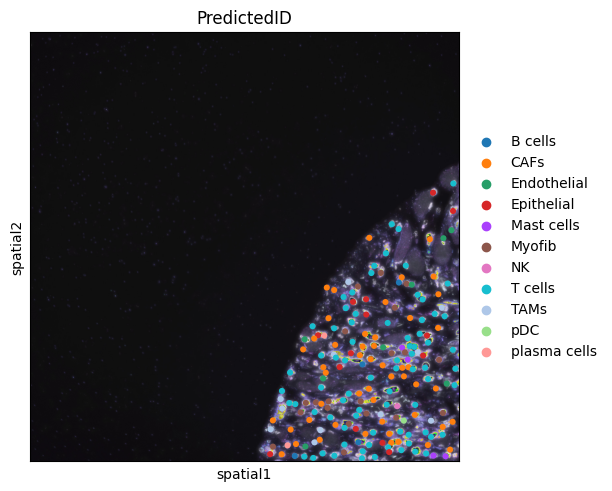

In [5]:
sq.pl.spatial_scatter(bot_adata, 
                      library_id='2_100',
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      # color='UTAG Label_leiden_0.1',
                      color='PredictedID',
                      size=60,
                      # title="Sample location: "+category,
                     )
plt.show()

## Do UTAG on bottom slide: 

In [6]:
from utag import utag


obs = bot_adata.obs[['fov', 'CenterX_global_px', 'CenterY_global_px']]
X = bot_adata.X.toarray()
X = X.astype(np.float64)
var = bot_adata.var

minimal_adata = anndata.AnnData(
    X = X,
    obs = obs,
    var = var
)

minimal_adata.obsm['spatial'] = np.array(minimal_adata.obs[['CenterY_global_px', 'CenterX_global_px']])

utag_results = utag(
    minimal_adata,
    slide_key="fov",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions=[0.1], # I ran the default sweep before and found this to be best
)

bot_adata.obs['UTAG Label_leiden_0.1'] = utag_results.obs['UTAG Label_leiden_0.1']


/sfs/qumulo/qhome/mr2ep/hack_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applying UTAG Algorithm...


/sfs/qumulo/qhome/mr2ep/hack_env/lib/python3.11/site-packages/parmap/parmap.py:123: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(exc))
  0%|          | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.1...


100%|██████████| 1/1 [02:33<00:00, 153.68s/it]


In [7]:
bot_adata.write_h5ad('preprocessed_bot-UTAG.h5ad')

In [8]:
top_adata = anndata.read_h5ad('preprocessed_top.h5ad')

obs = top_adata.obs[['fov', 'CenterX_global_px', 'CenterY_global_px']]
X = top_adata.X.toarray()
X = X.astype(np.float64)
var = top_adata.var

minimal_adata = anndata.AnnData(
    X = X,
    obs = obs,
    var = var
)

minimal_adata.obsm['spatial'] = np.array(minimal_adata.obs[['CenterY_global_px', 'CenterX_global_px']])

utag_results = utag(
    minimal_adata,
    slide_key="fov",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions=[0.1], # I ran the default sweep before and found this to be best
)

top_adata.obs['UTAG Label_leiden_0.1'] = utag_results.obs['UTAG Label_leiden_0.1']

top_adata.write_h5ad('preprocessed_top-UTAG.h5ad')


Applying UTAG Algorithm...


/sfs/qumulo/qhome/mr2ep/hack_env/lib/python3.11/site-packages/parmap/parmap.py:123: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(exc))
  0%|          | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.1...


100%|██████████| 1/1 [00:58<00:00, 58.63s/it]


## Find the cell type composition of cluster 1,3,5 vs 0,2,4

## Compare the frequency of the composition in each of the UTAG leiden clusters for 0.1 using the annotated cell types

In [7]:
import anndata
import pandas as pd
import numpy as np

top_adata = anndata.read_h5ad('preprocessed_top-UTAG.h5ad')
bot_adata = anndata.read_h5ad('preprocessed_bottom-UTAG.h5ad')

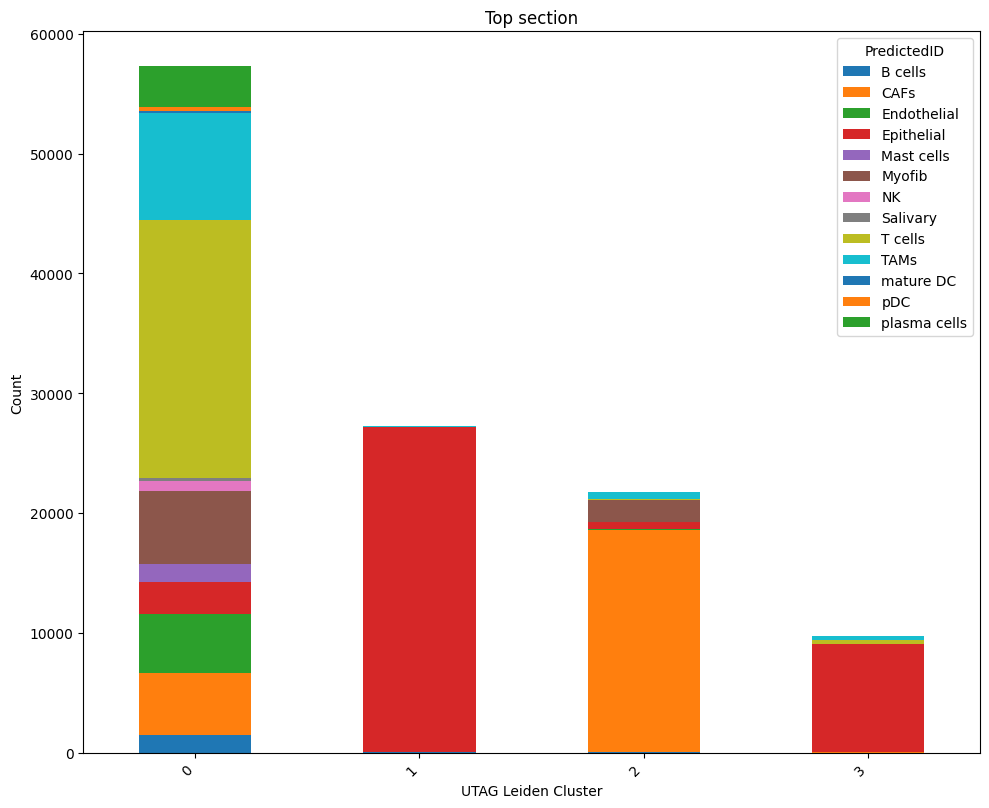

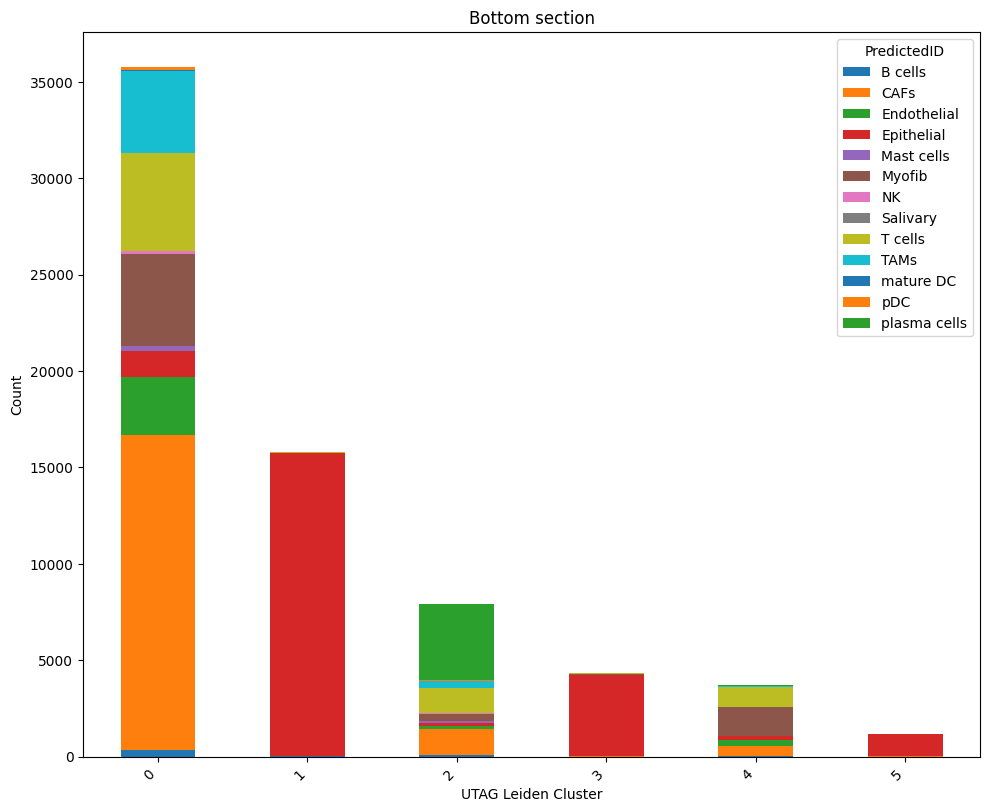

In [8]:
import matplotlib.pyplot as plt

cluster_compositions = {}
for cluster in top_adata.obs['UTAG Label_leiden_0.1'].unique():
    cluster_adata = top_adata[top_adata.obs['UTAG Label_leiden_0.1'] == cluster]
    cluster_compositions[int(cluster)] = cluster_adata.obs['PredictedID'].value_counts() 
    

cluster_comp_df = pd.DataFrame(cluster_compositions)
cluster_comp_df.fillna(0, inplace=True)
cluster_comp_df = cluster_comp_df.T
cluster_comp_df.sort_index(inplace=True)

ax = cluster_comp_df.plot(kind='bar', stacked=True, figsize=(10, 8))
ax.set_ylabel('Count')
ax.set_xlabel('UTAG Leiden Cluster')

# Show the plot
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.title("Top section")
plt.show()

cluster_compositions = {}
for cluster in bot_adata.obs['UTAG Label_leiden_0.1'].unique():
    cluster_adata = bot_adata[bot_adata.obs['UTAG Label_leiden_0.1'] == cluster]
    cluster_compositions[cluster] = cluster_adata.obs['PredictedID'].value_counts() 
    

cluster_comp_df = pd.DataFrame(cluster_compositions)
cluster_comp_df.fillna(0, inplace=True)
cluster_comp_df = cluster_comp_df.T
cluster_comp_df.sort_index(inplace=True)

ax = cluster_comp_df.plot(kind='bar', stacked=True, figsize=(10, 8))
ax.set_ylabel('Count')
ax.set_xlabel('UTAG Leiden Cluster')

# Show the plot
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.title("Bottom section")
plt.show()


In [9]:
section_map = {
    '0' : 'Stroma',
    '1' : 'Tumor', 
    '2' : 'Stroma',
    '3' : 'Tumor', 
    '4' : 'Stroma',
    '5' : 'Tumor', 
}

bot_adata.obs['region'] = bot_adata.obs['UTAG Label_leiden_0.1'].map(section_map)
top_adata.obs['region'] = top_adata.obs['UTAG Label_leiden_0.1'].map(section_map)

## What is the amount of panck associated with each cluster?

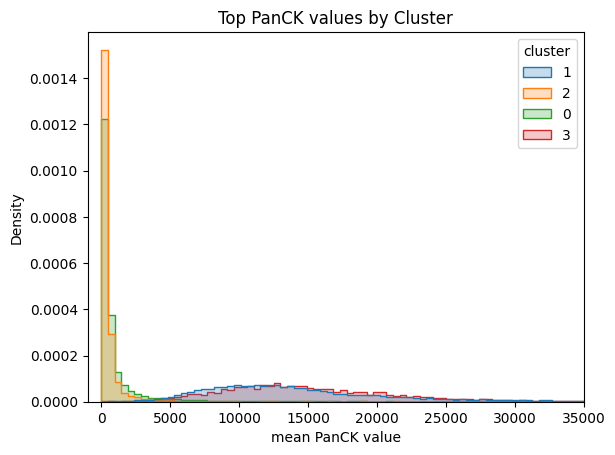

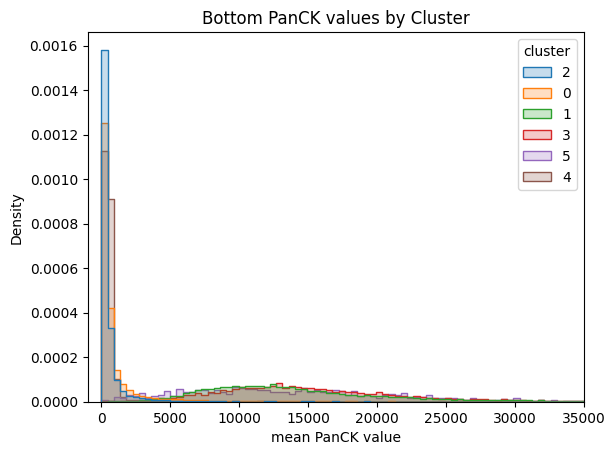

In [15]:
import seaborn as sns

bot_data = []
for i, cluster in enumerate(bot_adata.obs['UTAG Label_leiden_0.1'].unique()):
    cluster_adata = bot_adata[bot_adata.obs['UTAG Label_leiden_0.1'] == cluster]
    for value in cluster_adata.obs['Mean.PanCK'].values:
        bot_data.append({'cluster':cluster, 
                     'value' : value})    
bot_panck_df = pd.DataFrame(bot_data)

top_data = []
for i, cluster in enumerate(top_adata.obs['UTAG Label_leiden_0.1'].unique()):
    cluster_adata = bot_adata[bot_adata.obs['UTAG Label_leiden_0.1'] == cluster]
    for value in cluster_adata.obs['Mean.PanCK'].values:
        top_data.append({'cluster':cluster, 
                     'value' : value})    
top_panck_df = pd.DataFrame(top_data)


sns.histplot(data=top_panck_df, x='value', hue='cluster', element='step', stat='density', common_norm=False)
plt.xlim([-1000,35000])
plt.title("Top PanCK values by Cluster")
plt.xlabel('mean PanCK value')
plt.ylabel('Density')
plt.show()
          
sns.histplot(data=bot_panck_df, x='value', hue='cluster', element='step', stat='density', common_norm=False)
plt.xlim([-1000,35000])
plt.title("Bottom PanCK values by Cluster")
plt.xlabel('mean PanCK value')
plt.ylabel('Density')
plt.show()

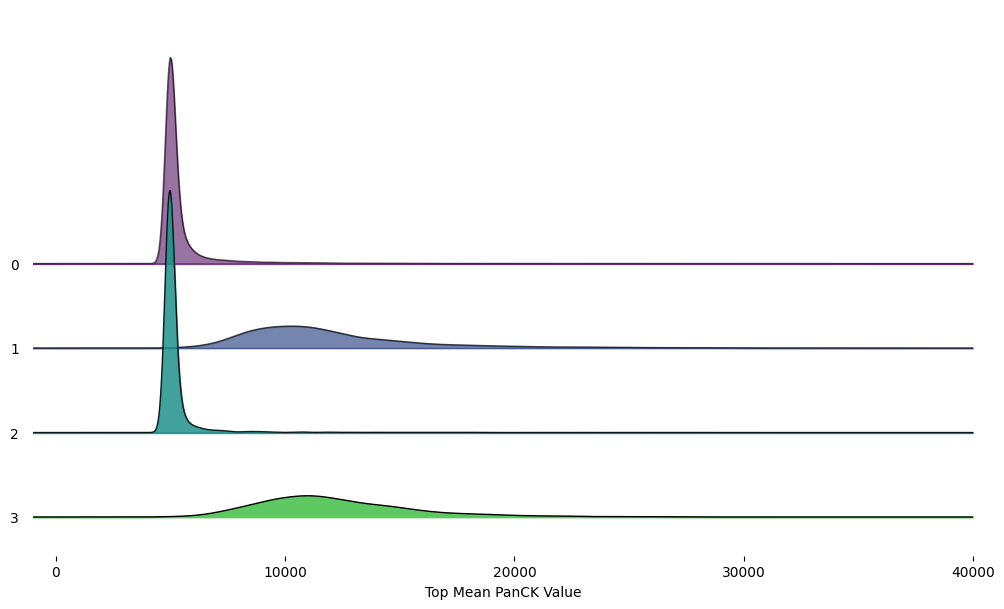

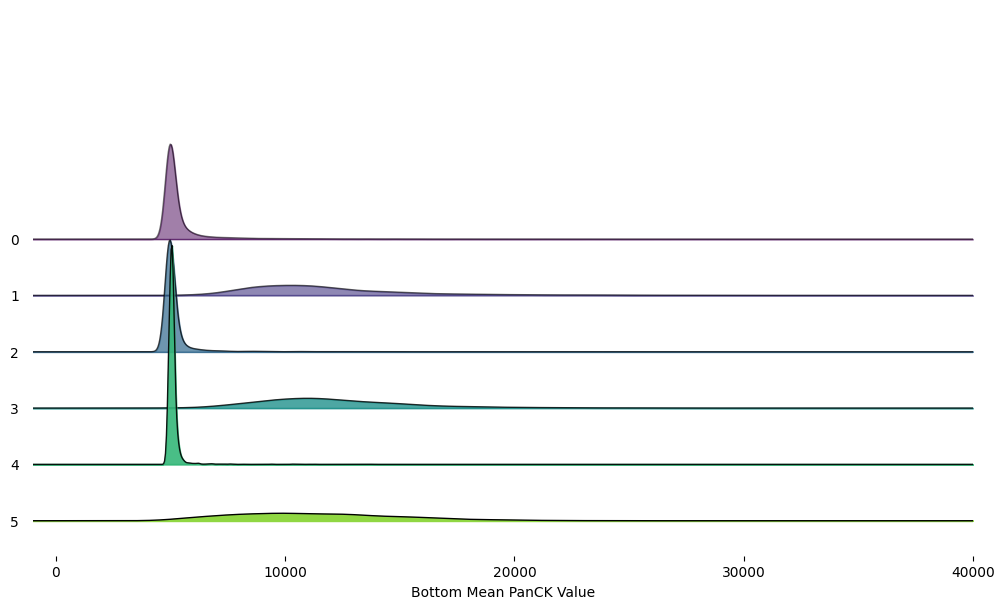

In [16]:
import joypy
import matplotlib.pyplot as plt

# Create the ridgeline plot
fig, axes = joypy.joyplot(top_panck_df, by='cluster', column='value', figsize=(10, 6), 
                          overlap=3, colormap=plt.cm.viridis, fade=True, linewidth=1)

# Adding titles and labels
plt.xlabel('Top Mean PanCK Value')
plt.ylabel('Cluster')
plt.xlim([-1000, 40000])

plt.show()


# Create the ridgeline plot
fig, axes = joypy.joyplot(bot_panck_df, by='cluster', column='value', figsize=(10, 6), 
                          overlap=3, colormap=plt.cm.viridis, fade=True, linewidth=1)

# Adding titles and labels
plt.xlabel('Bottom Mean PanCK Value')
plt.ylabel('Cluster')
plt.xlim([-1000, 40000])

plt.show()



# Clusters 0, 2, and 4 look like the stroma and the remainder is cancer!!

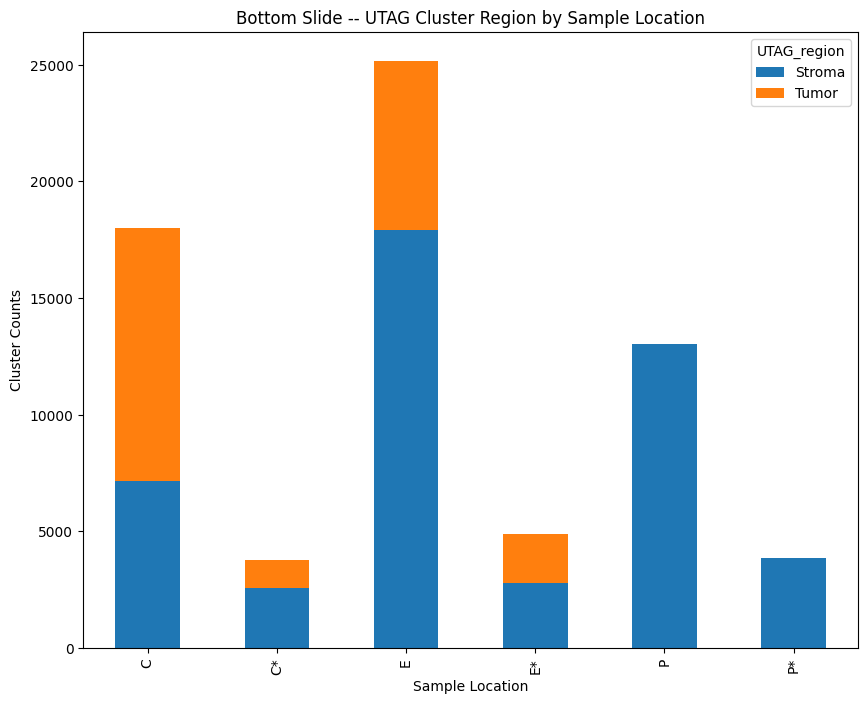

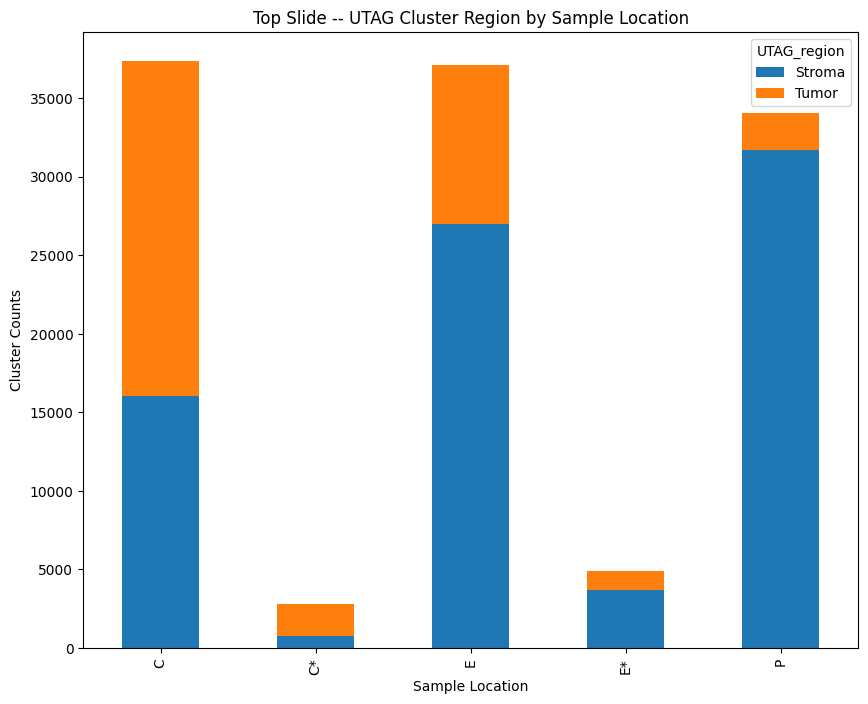

In [21]:
# For each tumor location, plot the UTAG cluster composition:

data = []

for i, sample_loc in enumerate(bot_adata.obs['Sample Location'].unique()):
    sample_loc_adata = bot_adata[bot_adata.obs['Sample Location'] == sample_loc]
    
    for region, counts in sample_loc_adata.obs['region'].value_counts().items():
        data.append({'sample_loc' : sample_loc, 
                     'UTAG_region' : region,
                     'cluster_counts' : counts,
                    })

location_comp_df = pd.DataFrame(data)
location_comp_df = location_comp_df.pivot_table(index='sample_loc', columns='UTAG_region', values='cluster_counts', fill_value=0)

ax = location_comp_df.plot(kind='bar', stacked=True, figsize=(10, 8))
ax.set_title('Bottom Slide -- UTAG Cluster Region by Sample Location')
ax.set_xlabel('Sample Location')
ax.set_ylabel('Cluster Counts')
plt.show()

# For each tumor location, plot the UTAG cluster composition:

data_top = []

for i, sample_loc in enumerate(top_adata.obs['Sample Location'].unique()):
    sample_loc_adata = top_adata[top_adata.obs['Sample Location'] == sample_loc]
    
    for region, counts in sample_loc_adata.obs['region'].value_counts().items():
        data_top.append({'sample_loc' : sample_loc, 
                     'UTAG_region' : region,
                     'cluster_counts' : counts,
                    })

location_comp_df = pd.DataFrame(data_top)
location_comp_df = location_comp_df.pivot_table(index='sample_loc', columns='UTAG_region', values='cluster_counts', fill_value=0)

# sns.histplot(location_comp_df, x='sample_loc', y=

ax = location_comp_df.plot(kind='bar', stacked=True, figsize=(10, 8))
ax.set_title('Top Slide -- UTAG Cluster Region by Sample Location')
ax.set_xlabel('Sample Location')
ax.set_ylabel('Cluster Counts')
plt.show()

### The sample location label keys:
- C: Center or core
- E: Leading edge or edge
- P: periphery or 'distal'

### Star note:
The stars correspond to the sequential slice from the bottom chip that is duplicated from the top chip. Unstarred locations are 

# TODO: 
1. Look at (per punch) percent celllularity
    - need to collect FOVs in a punch
2. Look at the cancer (called epithelial) in the 0 UTAG cluster
3. ELBO plot for cluster (resolution param)
4. Compare the stars to look at the profiles of the sequential section
    - Look at the sequential sections with the fit UTAG
    - Do the UTAG seperately for the top vs bottom and them compare the results

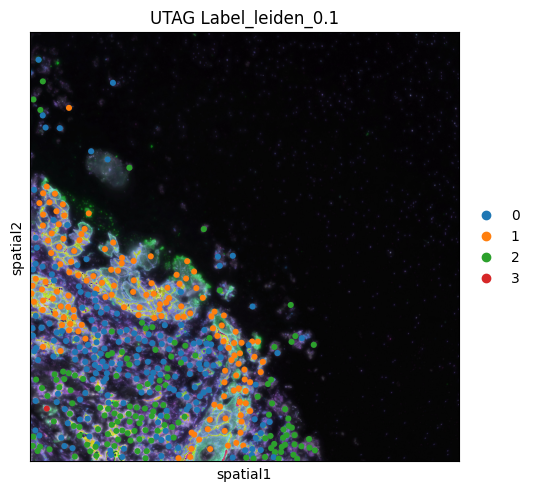

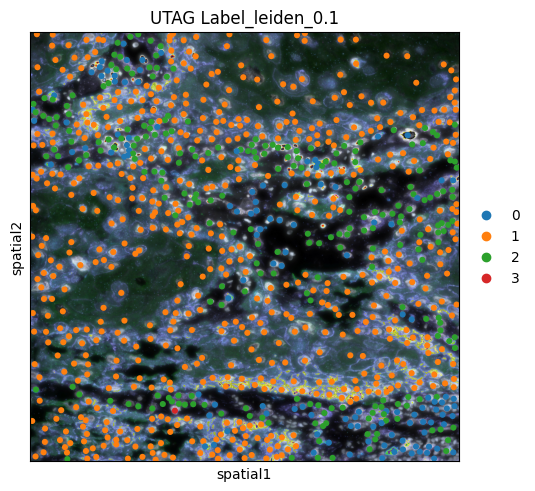

In [24]:
sq.pl.spatial_scatter(top_adata, 
                      library_id='1_12',
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='UTAG Label_leiden_0.1',
                      # color='PredictedID',
                      size=60,
                      # title="Sample location: "+category,
                     )
plt.show()

sq.pl.spatial_scatter(bot_adata, 
                      library_id='2_5',
                      library_key='fov', 
                      seg_cell_id='seg_cell_ID',
                      color='UTAG Label_leiden_0.1',
                      # color='PredictedID',
                      size=60,
                      # title="Sample location: "+category,
                     )
plt.show()